In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

# local imports
from prepare import *

In [2]:
train = pd.read_csv('data/train.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')
#specs = pd.read_csv('data/specs.csv')
#sample = pd.read_csv('data/sample_submission.csv')

In [3]:
train.shape

(11341042, 11)

## Run modified remove_dead_weight function

In [4]:
train = remove_dead_weight(train, train_labels)
test = remove_dead_weight(test, train_labels, test_set=True)

In [5]:
train.shape

(7696400, 11)

## Process time

In [6]:
# convert timestamp to correct datetime type
train['timestamp'] = pd.to_datetime(train['timestamp'], infer_datetime_format=True)
test['timestamp'] = pd.to_datetime(test['timestamp'], infer_datetime_format=True)

In [7]:
# have the ability to break datetime into year, month, day, etc with add_datepart in library

## Encode data

https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

In [8]:
train, test = encode_col(train, test, 'title')
train, test = encode_col(train, test, 'world')

In [9]:
train.shape

(7696400, 59)

## Process Data

https://www.kaggle.com/ragnar123/truncated-train-ensemble

In [10]:
compiled_train_data = process_data(train)
compiled_test_data = process_data(test, test_set=True)

In [11]:
len(compiled_train_data)

17690

In [12]:
new_train = pd.concat(compiled_train_data, axis=1).T

In [13]:
new_train.shape

(17690, 70)

In [14]:
new_train.to_pickle('data/new_train.pkl')

In [15]:
new_test = pd.concat(compiled_test_data, axis=1).T

In [16]:
new_test.to_pickle('data/new_test.pkl')

## Post Processed

In [16]:
reduced_train = pd.read_pickle('data/new_train.pkl')
reduced_test = pd.read_pickle('data/new_test.pkl')

train_labels = pd.read_csv('data/train_labels.csv')

In [18]:
reduced_train = reduced_train.merge(train_labels, on=['game_session', 'installation_id', 'title'])

In [31]:
drops = ['event_id', 'game_session', 'timestamp', 'event_data', 'installation_id', 'event_code', 'type', 'world', 
         'installation_id_slice', 'title', 'num_correct', 'num_incorrect', 'accuracy', 'accuracy_group']

In [33]:
X = reduced_train.drop(drops, axis=1)
y = reduced_train['accuracy_group']

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Predict

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf = RandomForestClassifier(random_state = 42)

In [40]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [41]:
y_pred = rf.predict(X_test)

## Evaluate

In [44]:
def eval_qwk_lgb_regr(y_true, y_pred, reduce_train):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', qwk3(y_true, y_pred), True

def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

def qwk3(a1, a2, max_rat=3):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [65]:
from sklearn.metrics import cohen_kappa_score

In [68]:
cohen_kappa_score(y_test, y_pred)

0.20075183823995735

('cappa', 0.1112194600912968, True)

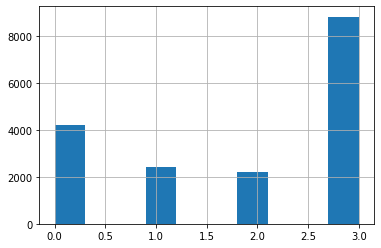

In [46]:
eval_qwk_lgb_regr(y_test, y_pred, reduced_train)

In [52]:
diffs = [y_test - y_pred]

In [63]:
len(diffs[0])

3538

In [64]:
len([x for x in diffs[0] if x != 0])

1692

## Calculate Accuracy Group

In [4]:
ts = train[train['installation_id'] == '0006a69f']

In [9]:
ts = ts[ts['game_session'] == '77b8ee947eb84b4e']

In [14]:
ts['event_data'].str.contains('false').sum()

30

In [ ]:
true_attempts = all_attempts['event_data'].str.contains('true').sum()
false_attempts = all_attempts['event_data'].str.contains('false').sum()

accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0

if accuracy == 0:
    features['accuracy_group'] = 0
elif accuracy == 1:
    features['accuracy_group'] = 3
elif accuracy == 0.5:
    features['accuracy_group'] = 2
else:
    features['accuracy_group'] = 1